In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import math
import random
# import scikitlearn as skt
from datetime import timedelta
from scipy.linalg import hankel, svd
import time

In [2]:
# Reading The Secure Water Treatment Dataset

df_normal = pd.read_excel('../Datasets/SWaT_Dataset_Normal_v0.xlsx')
df_attack = pd.read_excel('../Datasets/SWaT_Dataset_Attack_v0.xlsx')

In [3]:
# There are a total of 55 sensors, we can choose either a random sensor or a fixed for PASAD Analysis
# We number the sensor from 0 to 54, we are using sensor ultra-filtration feed water tank level sensor signal LIT301 and the water pH analyzer sensor signal AIT202

Sensors_SWaT = ["FIT101", "LIT101", "MV101", "P101", "P102", "AIT201", "AIT202", "AIT203", "FIT201", "MV201", "P201", "P202", "P203", "P204", "P205", "P206", "DPIT301", "FIT301", "LIT301", "MV301", "MV302", "MV303", "MV304", "P301", "P302", "AIT401", "AIT402", "FIT401", "LIT401", "P401", "P402", "P403", "P404", "UV401", "AIT501", "AIT502", "AIT503", "AIT504", "FIT501", "FIT502", "FIT503", "FIT504", "P501", "P502", "PIT501", "PIT502", "PIT503", "FIT601", "P601", "P602", "P603"]

Sensor_SWaT = random.choice(Sensors_SWaT)
Sensor_SWaT = "LIT301"

print("The Sensor being studied is", Sensor_SWaT)

TrainingValues = int(60*60*4)
TestingValues = int(60*60*20)

SWaT = df_normal[Sensor_SWaT].tail(TrainingValues).to_list()
SWaT.extend(df_attack[Sensor_SWaT].head(TestingValues).to_list())
SWaT = np.array(SWaT)

The Sensor being studied is LIT301


In [4]:
# Reading the  Tennessee-Eastman Chemical challenge process

# There are a total of 41 sensors, we can choose either a random sensor or a fixed for PASAD Analysis
# We number the sensor from 0 to 40, the most instructive results are seen for sensor number 0 and 7
Sensor_Number_TE = random.randint(0, 40)
Sensor_Number_TE = 9

print("The Sensor being studied is", Sensor_Number_TE)

sa1 = np.genfromtxt('../Datasets/sa1.csv', delimiter=',')[:, Sensor_Number_TE]
sa2 = np.genfromtxt('../Datasets/sa2.csv', delimiter=',')[:, Sensor_Number_TE]
sa3 = np.genfromtxt('../Datasets/sa3.csv', delimiter=',')[:, Sensor_Number_TE]
da1 = np.genfromtxt('../Datasets/da1.csv', delimiter=',')[:, Sensor_Number_TE]
da2 = np.genfromtxt('../Datasets/da2.csv', delimiter=',')[:, Sensor_Number_TE]

The Sensor being studied is 9


In [5]:
# Reading all the Global Variables for our analysis

# The Sufficient Variance that you need for generalizing the Sensor Reading Variations
# Kindly choose a value between 0.8 to 0.9 for best results
Sufficient_Variance_to_Capture = 0.85

# The lag parameter of the time series analysis we are doing via Pasad. We can try multiple values to get the best results
LagParameter_TE =  1000
LagParameter_SWaT =  int(60*60*3)

In [6]:
len(SWaT)

86400

In [7]:
SWaT

array([836.8447, 837.0049, 836.9649, ..., 884.0281, 883.4274, 883.0268])

In [8]:
def Pasad (TrainData, TestData, LagParameter = LagParameter_TE, VaraianceLimit = Sufficient_Variance_to_Capture, Signal = 0):
    

    # Computing Length Parameter of the time series
    Num_TrainingPoints = len(TrainData)
    Num_TestingPoints = len(TestData)


    # Step 1: Embedding

    # Rows and Columns for the Hankel Matrix
    Num_Rows = LagParameter
    Num_Columns_train = Num_TrainingPoints - LagParameter + 1
    Num_Columns_test = Num_TestingPoints - LagParameter + 1

    # Construct the Hankel Matrix also called the Lag Covariance Matrix
    # The columns of the Hankel Matrix are the Lagged Vectors
    hankel_matrix = hankel(TrainData[0 : Num_Rows], TrainData[Num_Rows - 1 : Num_TrainingPoints])
    hankel_matrix_test = hankel(TestData[0 : Num_Rows], TestData[Num_Rows - 1 : Num_TestingPoints])


    # Step 2: Singular Value Decomposition (SVD)

    # SVD will break M = U * S * V_T, where U is the left singular matrix, S is the diagonal matrix of Singular Values and V_T is transpose of right singular matrix
    # svd returns a 1-D array of singular values as the second output

    U, SingularValues, V_T = svd(hankel_matrix)
    
    # Diagonal matrix of singular values
    SingularValuesMatrix = np.diag(SingularValues)

    # Removing the first Singular Value as it most likely retains a noise dimension
    SingularValues = SingularValues[1:]

    # Calculating the Cumulative Strength of the eigen vectors
    
    # for i in SingularValues:

    CumulativeSingularValuesShare = np.cumsum(SingularValues) / np.sum(SingularValues)
    SingularValuesShare = SingularValues/np.sum(SingularValues)

    # Compute the Statistical Dimension
    for i, share in enumerate(CumulativeSingularValuesShare):
        if share >= VaraianceLimit:
            statisticalDimension = i + 1
            break

    print(f'Statistical Dimension: {statisticalDimension}')

    # Plotting a Scree Plot
    SingularValueNumberArray = np.arange(1, len(CumulativeSingularValuesShare) + 1)

    # Plot for cumulative sum of eigenvalues
    plt.figure(figsize=(12, 5))

    # Scatter and line plot for cumulative singular values share
    plt.subplot(1, 2, 1)
    plt.scatter(SingularValueNumberArray, CumulativeSingularValuesShare, label='Cumulative Share', color='blue', s=50)
    plt.plot(SingularValueNumberArray, CumulativeSingularValuesShare, color='blue', alpha=0.5)
    plt.axhline(y=VaraianceLimit, color='red', linestyle='--', label='Variance Limit Threshold')
    plt.axvline(x=statisticalDimension, color='green', linestyle='--', label='Statistical Dimension')
    plt.title('Cumulative Share of Singular Values')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('Cumulative Share')
    plt.legend()
    plt.grid()

    # Plot for singular values Shares
    plt.subplot(1, 2, 2)
    plt.scatter(SingularValueNumberArray, SingularValuesShare, label='Singular Values', color='orange', s=20)
    plt.plot(SingularValueNumberArray, SingularValuesShare, color='orange', alpha=0.5)
    plt.axvline(x=statisticalDimension, color='green', linestyle='--', label='Statistical Dimension')
    plt.title('Singular Values')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.clf()
    
    # Step 3: Projection onto Linear Map

    # We left the first singular value because of noise
    # The transpose of this matrix will be used for transformation
    OrthonormalBasis = U[0 : , 1 : statisticalDimension + 1]

    # The test for Orthonormality
    # s = 0
    # for i in U[0]:
    #     s += i
    # print(s)

    # The central tendency for computation and its projection
    CentralTendency = np.mean(hankel_matrix, axis = 1)
    ProjectedCentralTendency = OrthonormalBasis @ OrthonormalBasis.T @ CentralTendency

    # print(len(ProjectedCentralTendency))


    # Step 4: Departure Score Computation
    DepartureScoreTrain = []
    DepartureScoreTest = []

    # print(hankel_matrix[0 : ,0], len(hankel_matrix[0 : ,0]))
    # print(Num_Columns_train)

    # Compute the Departure Scores for each training data point
    # Choose the maximum of these Departure Scores as the threshold Theta for zero false alarm rate
    # 0 represents normal while 1 represents alarm

    count = 0
    timeStart = time.time()
    Threshold = 0
    for i in range(Num_Columns_train):

        trainingPoint = hankel_matrix[0 : , i]
        distance = ProjectedCentralTendency - OrthonormalBasis @ OrthonormalBasis.T @ trainingPoint
        DepartureScore = math.sqrt(distance.T @ distance)
        count += 1
        Threshold = max(Threshold, DepartureScore)
        DepartureScoreTrain.append([DepartureScore, 0])

    # print(DepartureScoreTrain)

    print("The threshold theta for Alarm is", Threshold)

    Alarms = 0

    for i in range(Num_Columns_test):

        testingPoint = hankel_matrix_test[0 : , i]
        distance = ProjectedCentralTendency - OrthonormalBasis @ OrthonormalBasis.T @ testingPoint
        DepartureScore = math.sqrt(distance.T @ distance)
        count += 1
        if DepartureScore > Threshold:
            Alarms += 1
            DepartureScoreTest.append([DepartureScore, 1])
        else:
            DepartureScoreTest.append([DepartureScore, 0])

    timeEnd = time.time()

    print("The total time taken for", count, "departure score computations is", timeEnd - timeStart, "Making the average time", (timeEnd - timeStart)/count)

    # Create reading numbers for training and testing data
    readingNumberTrain = np.arange(1, len(DepartureScoreTrain) + 1)
    readingNumberTest = np.arange(len(DepartureScoreTrain) + 1, len(DepartureScoreTrain) + len(DepartureScoreTest) + 1)

    # Extract scores and values from the tuples
    train_scores = np.array([score for score, value in DepartureScoreTrain])
    train_values = np.array([value for score, value in DepartureScoreTrain])

    test_scores = np.array([score for score, value in DepartureScoreTest])
    test_values = np.array([value for score, value in DepartureScoreTest])

    # Create reading numbers for test scores based on conditions
    normal_indices = np.where(test_values == 0)[0]
    alarm_indices = np.where(test_values == 1)[0]

    # Use the indices to get corresponding reading numbers
    readingNumberTestNormal = readingNumberTest[normal_indices]
    readingNumberTestAlarm = readingNumberTest[alarm_indices]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(readingNumberTrain, train_scores, label='Training', color='blue')

    # Plot test scores for normal and alarm conditions
    plt.plot(readingNumberTestNormal, test_scores[normal_indices], label='Test - Normal', color='black')
    plt.plot(readingNumberTestAlarm, test_scores[alarm_indices], label='Test - Alarm', color='darkred')

    # Add threshold line
    plt.axhline(y=Threshold, color='green', linestyle='--', label='Threshold')

    # Add vertical line separating training and testing data
    plt.axvline(x=len(train_scores) + 0.5, color='purple', linestyle='--')

    # Adding labels and legend
    plt.title("Departure Scores for the Sensor Data")
    plt.xlabel("Reading Number")
    plt.ylabel("Departure Score")
    plt.legend()
    plt.grid()
    plt.show()
    plt.clf()

    if Signal == 0:
        # Concatenate training and test data
        data = np.concatenate([TrainData, TestData[LagParameter - 1 : ]])

        readingNumberTrain = np.arange(1, len(TrainData) + 1)
        readingNumberTest = np.arange(len(TrainData) + 1, len(data) + 1)

        # Generate reading numbers for training and test data
        reading_number_train = np.arange(1, len(TrainData) + 1)
        reading_number_test = np.arange(len(TrainData) + 1, len(data) + 1)

        # Second part: rolling average for the rest of the data
        # Note the adjustment to avoid mismatched array lengths
        sensor_signal= np.convolve(data, np.ones(LagParameter) / LagParameter, mode='valid')

        # Create the plot
        plt.figure(figsize=(12, 8))

        # Plot the sensor data: training, normal test, alarm test
        plt.plot(reading_number_train, TrainData, label='Training Data', color='blue')
        plt.plot(readingNumberTestNormal + LagParameter, TestData[normal_indices], label='Test - Normal', color='black')
        plt.plot(readingNumberTestAlarm + LagParameter, TestData[alarm_indices], label='Test - Alarm', color='darkred')

        # Plot the sensor signal
        plt.plot(np.arange(1 + LagParameter, len(data) + 2), sensor_signal, label='Sensor Signal', color='green', linewidth=3)

        # Plot the vertical line separating training and testing data
        plt.axvline(x=len(TrainData) + 0.5, color='purple', linestyle='--', label='Train/Test Separation')

        # Add titles and labels
        plt.title('Sensor Measurements with Training, Normal Test, and Alarm Test Data', fontsize=16)
        plt.xlabel('Reading Number', fontsize=14)
        plt.ylabel('Sensor Measurement', fontsize=14)

        # Add legend
        plt.legend(fontsize=12)

        # Show the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        # Concatenate training and test data
        data = np.concatenate([TrainData, TestData[LagParameter - 1 : ]])

        readingNumberTrain = np.arange(1, len(TrainData) + 1)
        readingNumberTest = np.arange(len(TrainData) + 1, len(data) + 1)

        # Generate reading numbers for training and test data
        reading_number_train = np.arange(1, len(TrainData) + 1)
        reading_number_test = np.arange(len(TrainData) + 1, len(data) + 1)

        # Create the plot
        plt.figure(figsize=(12, 8))

        # Plot the sensor data: training, normal test, alarm test
        plt.plot(np.arange(1, len(data) + 1), data, label='Test', color='black')

        # Plot the vertical line separating training and testing data
        plt.axvline(x=len(TrainData) + 0.5, color='purple', linestyle='--', label='Train/Test Separation')

        # Add titles and labels
        plt.title('Sensor Measurements with Training, Normal Test, and Alarm Test Data', fontsize=16)
        plt.xlabel('Reading Number', fontsize=14)
        plt.ylabel('Sensor Measurement', fontsize=14)

        # Add legend
        plt.legend(fontsize=12)

        # Show the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    # print(len(sensor_signal), len(data))

    print("The total number of Alarms raised are", Alarms)
    return Alarms



In [9]:
# Tennessee Eastman Dataset

# Defining an empty dictionary to store the alarm count
AlarmCountDict = dict()

# Defining a variable to store the average time taken
AverageTimeTaken = 0

Statistical Dimension: 409


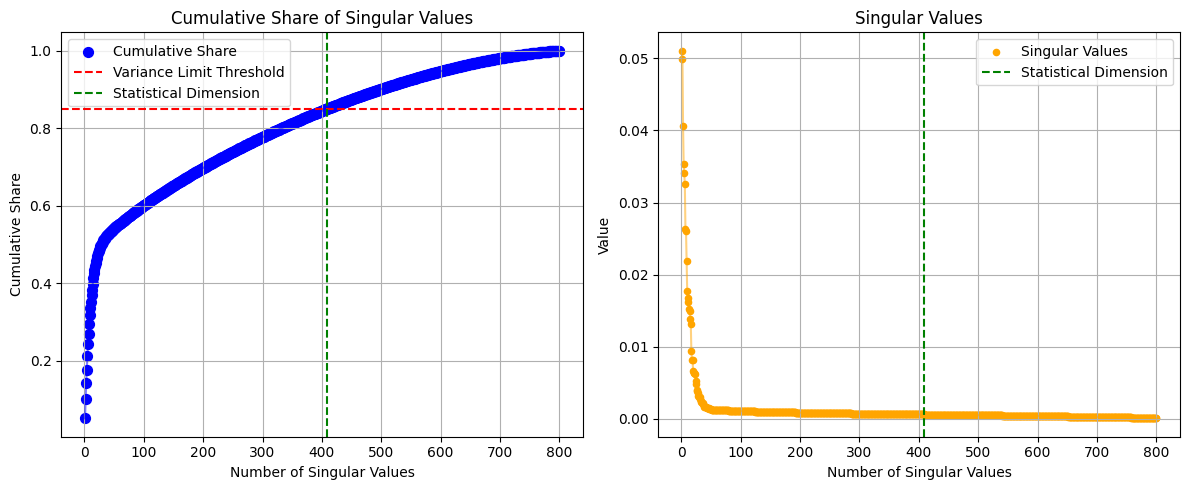

The threshold theta for Alarm is 0.379082825634274
The total time taken for 3802 departure score computations is 125.16287660598755 Making the average time 0.032920272647550645


<Figure size 640x480 with 0 Axes>

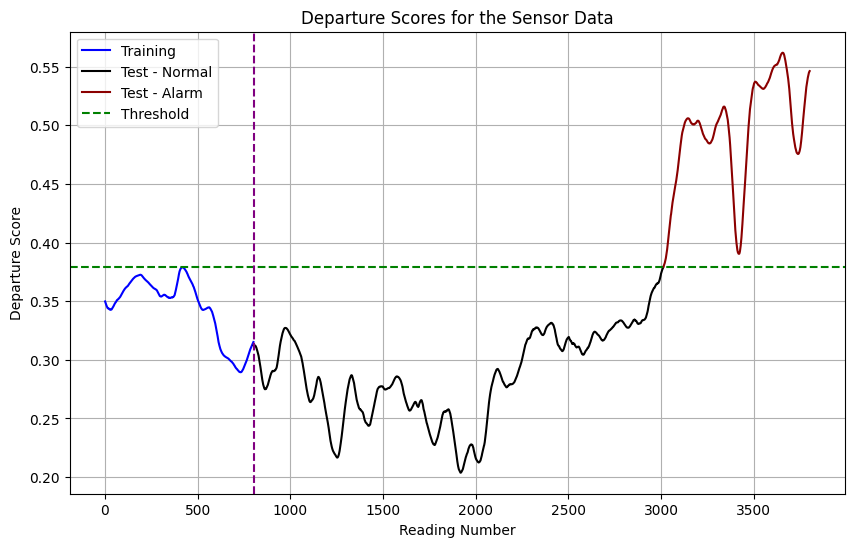

<Figure size 640x480 with 0 Axes>

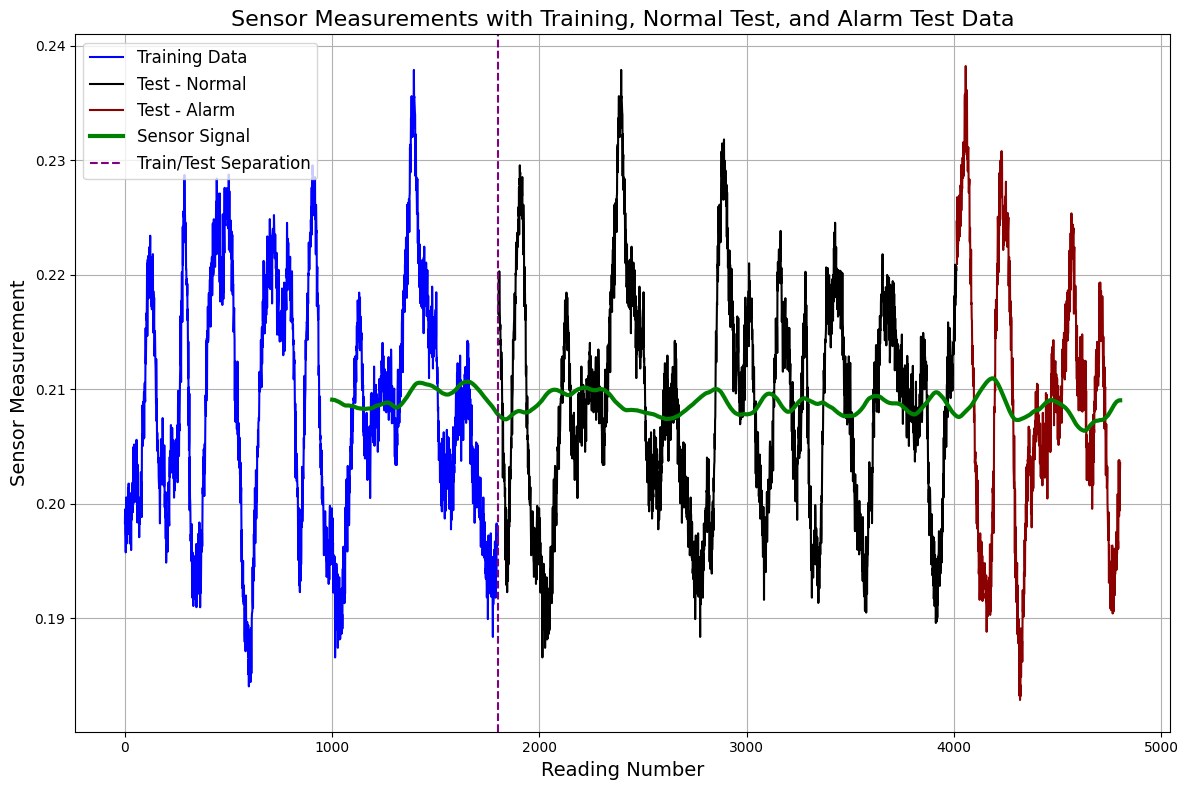

The total number of Alarms raised are 790
Time Taken: 141.32991480827332 seconds


In [10]:
# Applying Pasad to the different Sensors for SA1

Start = time.time()
AlarmCountDict['SA1'] = Pasad(sa1[0:1800], sa1[1800 - LagParameter_TE + 1:], LagParameter_TE, Sufficient_Variance_to_Capture)
End = time.time()

AverageTimeTaken += End - Start
print("Time Taken:", End - Start, "seconds")

Statistical Dimension: 411


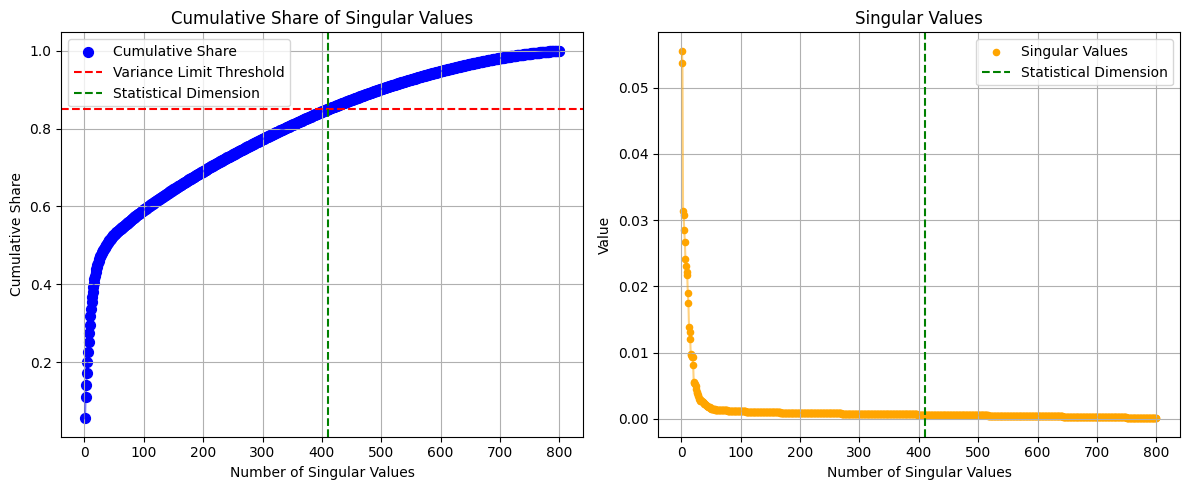

The threshold theta for Alarm is 0.36252685533312584
The total time taken for 3802 departure score computations is 106.80085968971252 Making the average time 0.028090704810550374


<Figure size 640x480 with 0 Axes>

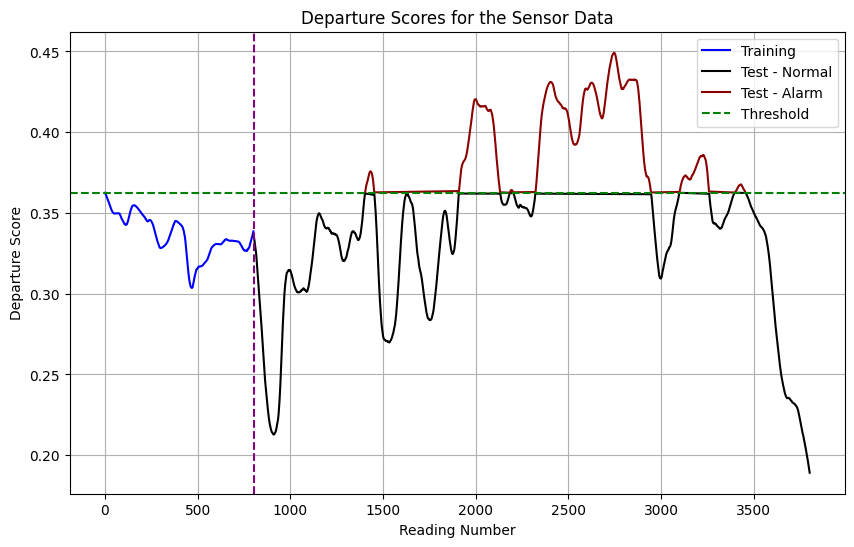

<Figure size 640x480 with 0 Axes>

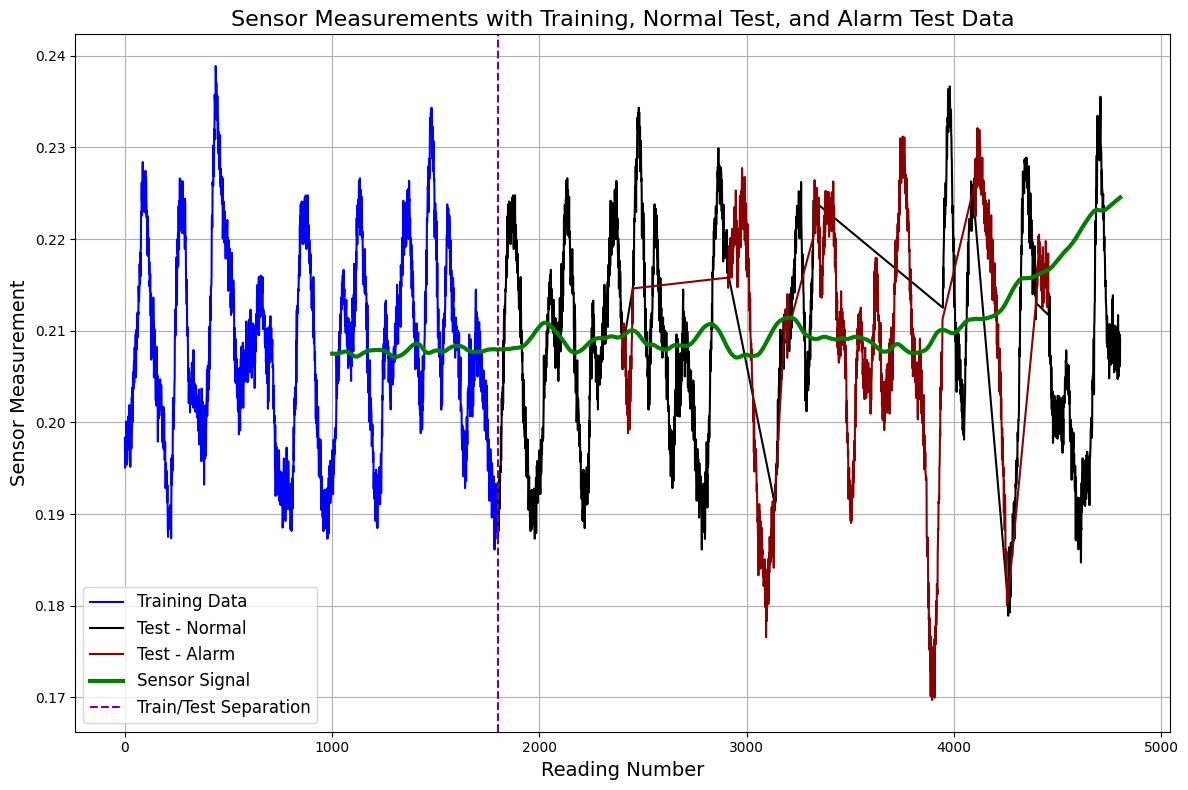

The total number of Alarms raised are 1134
Time Taken: 113.63207387924194 seconds


In [11]:
# Applying Pasad to the different Sensors for SA2

Start = time.time()
AlarmCountDict['SA2'] = Pasad(sa2[0:1800], sa2[1800 - LagParameter_TE + 1:], LagParameter_TE, Sufficient_Variance_to_Capture)
End = time.time()

AverageTimeTaken += End - Start
print("Time Taken:", End - Start, "seconds")

Statistical Dimension: 422


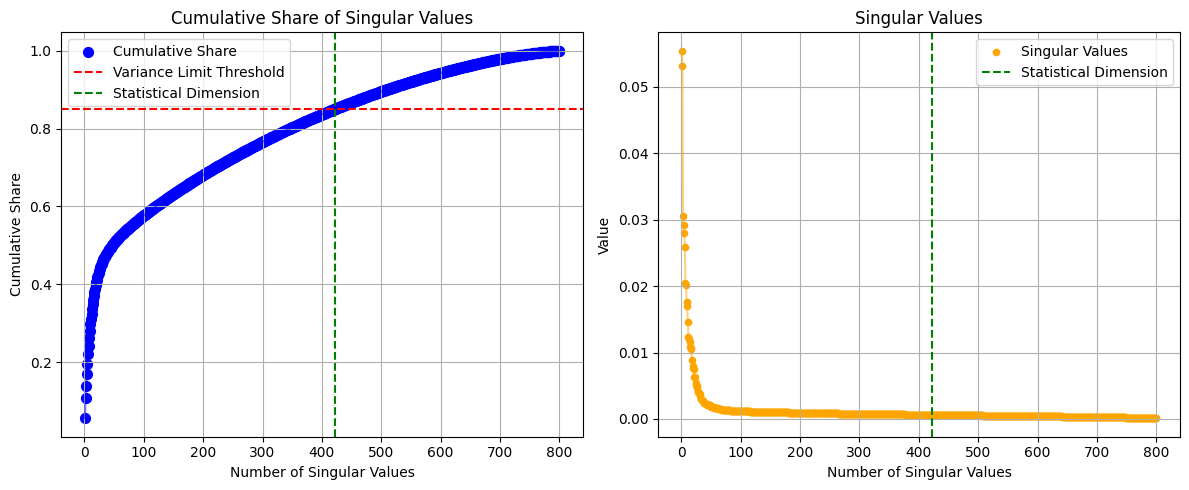

The threshold theta for Alarm is 0.40710230705983624
The total time taken for 3802 departure score computations is 51.27291774749756 Making the average time 0.013485775314965165


<Figure size 640x480 with 0 Axes>

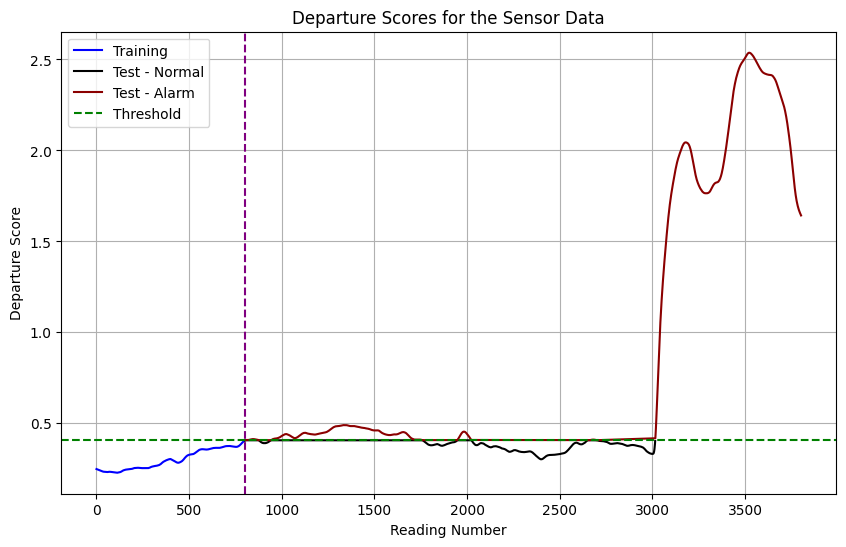

<Figure size 640x480 with 0 Axes>

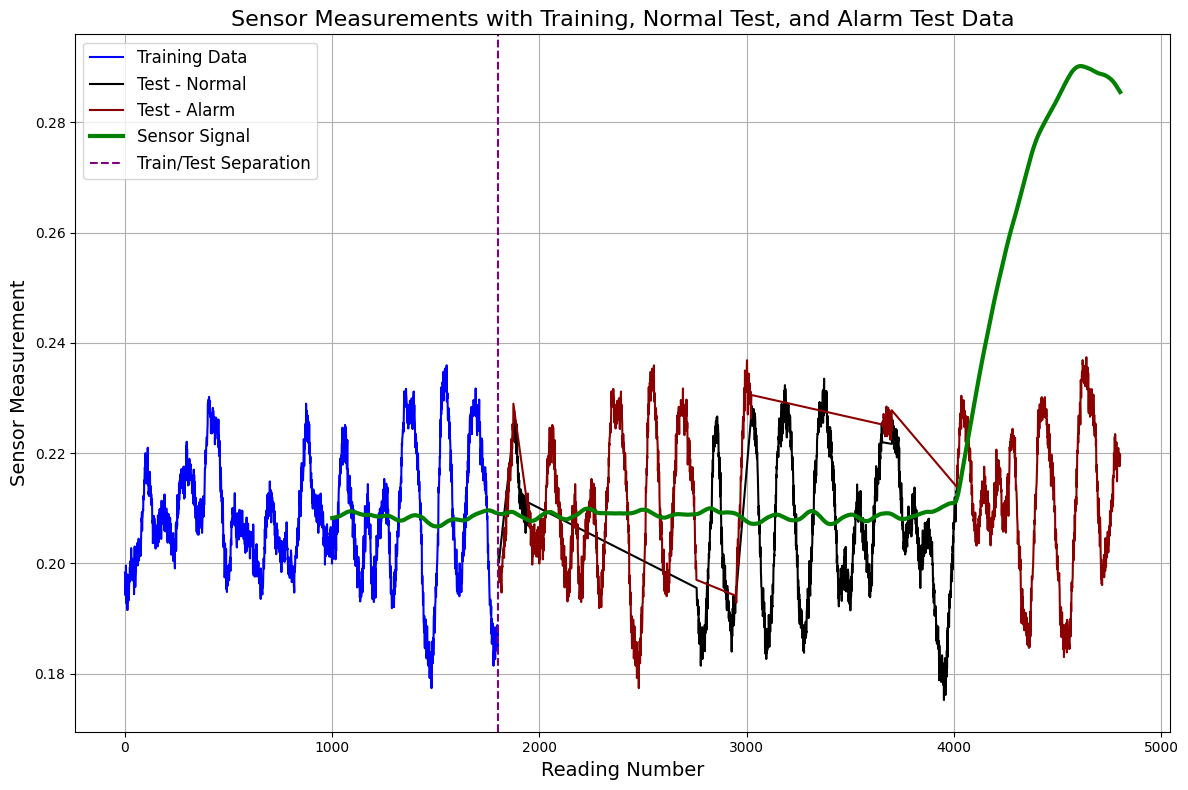

The total number of Alarms raised are 1795
Time Taken: 55.16662311553955 seconds


In [12]:
# Applying Pasad to the different Sensors for SA3

Start = time.time()
AlarmCountDict['SA3'] = Pasad(sa3[0:1800], sa3[1800 - LagParameter_TE + 1:], LagParameter_TE, Sufficient_Variance_to_Capture)
End = time.time()

AverageTimeTaken += End - Start
print("Time Taken:", End - Start, "seconds")

Statistical Dimension: 396


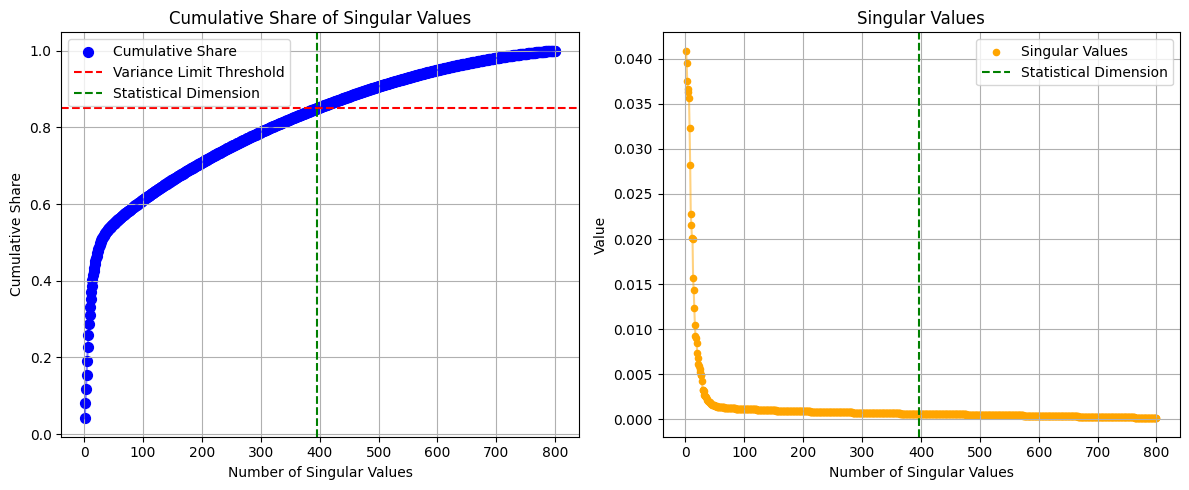

The threshold theta for Alarm is 0.4033350334636766
The total time taken for 3802 departure score computations is 40.12897491455078 Making the average time 0.010554701450434188


<Figure size 640x480 with 0 Axes>

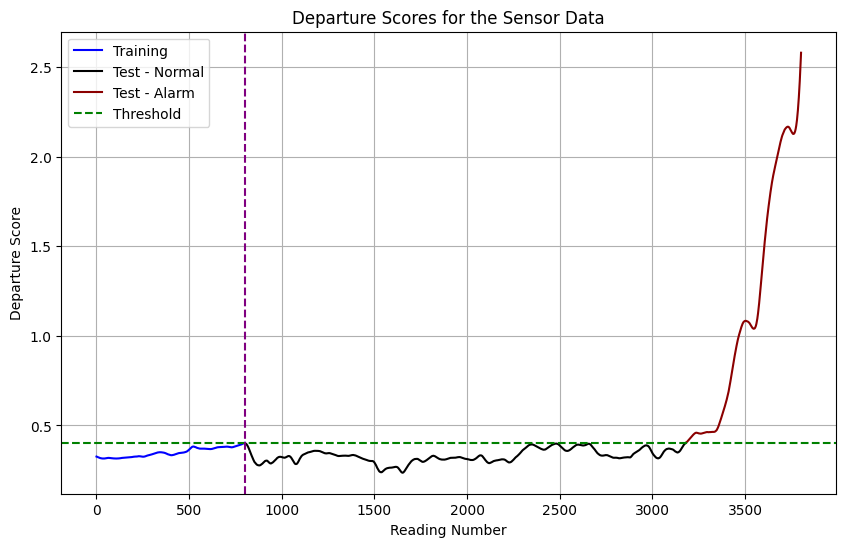

<Figure size 640x480 with 0 Axes>

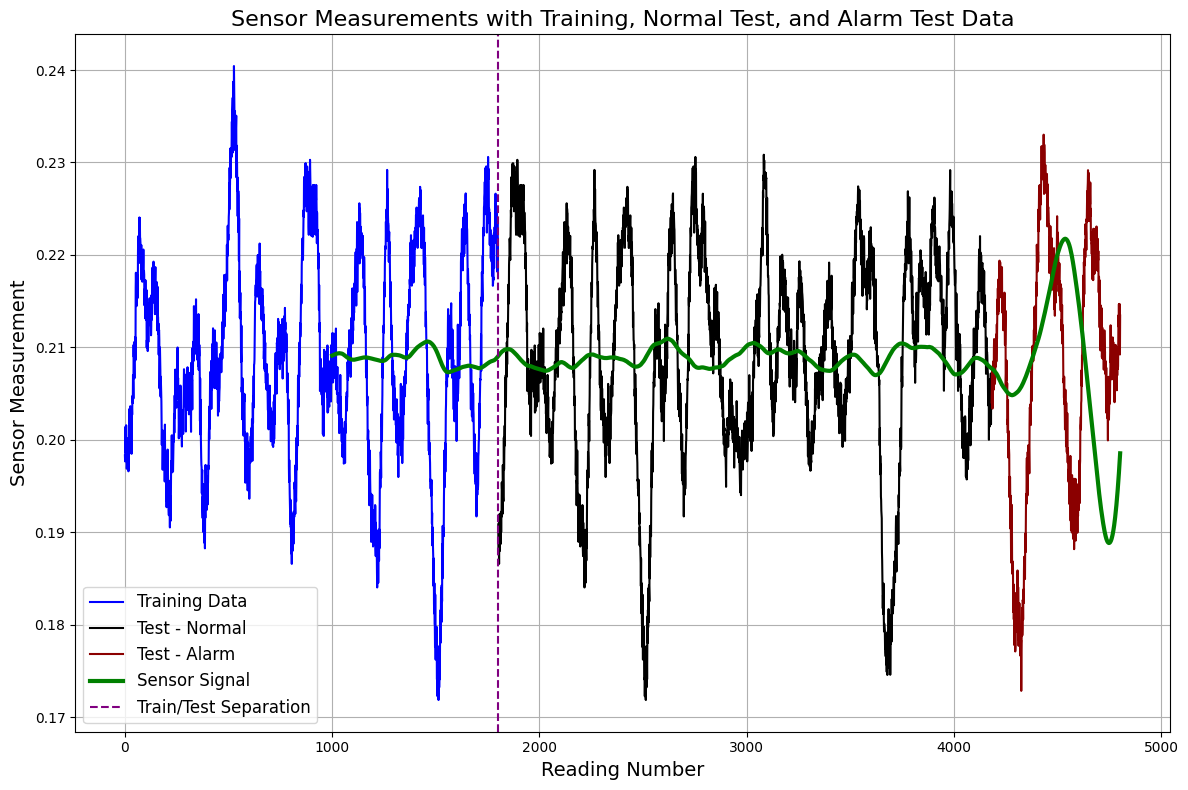

The total number of Alarms raised are 621
Time Taken: 42.869229793548584 seconds


In [13]:
# Applying Pasad to the different Sensors for DA1

Start = time.time()
AlarmCountDict['DA1'] = Pasad(da1[0:1800], da1[1800 - LagParameter_TE + 1:], LagParameter_TE, Sufficient_Variance_to_Capture)
End = time.time()

AverageTimeTaken += End - Start
print("Time Taken:", End - Start, "seconds")

Statistical Dimension: 366


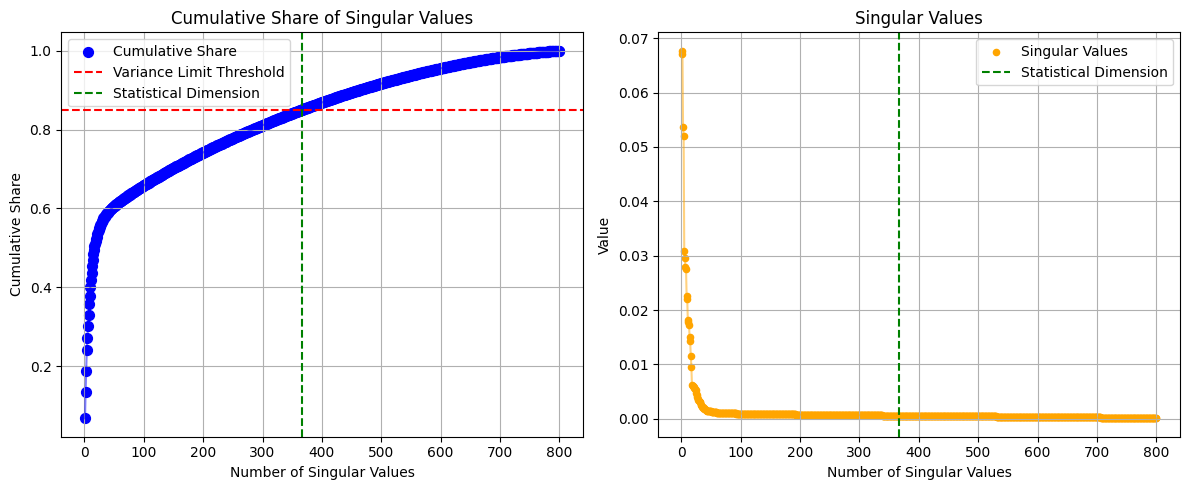

The threshold theta for Alarm is 0.5236125305141435
The total time taken for 3802 departure score computations is 36.522911071777344 Making the average time 0.00960623647337647


<Figure size 640x480 with 0 Axes>

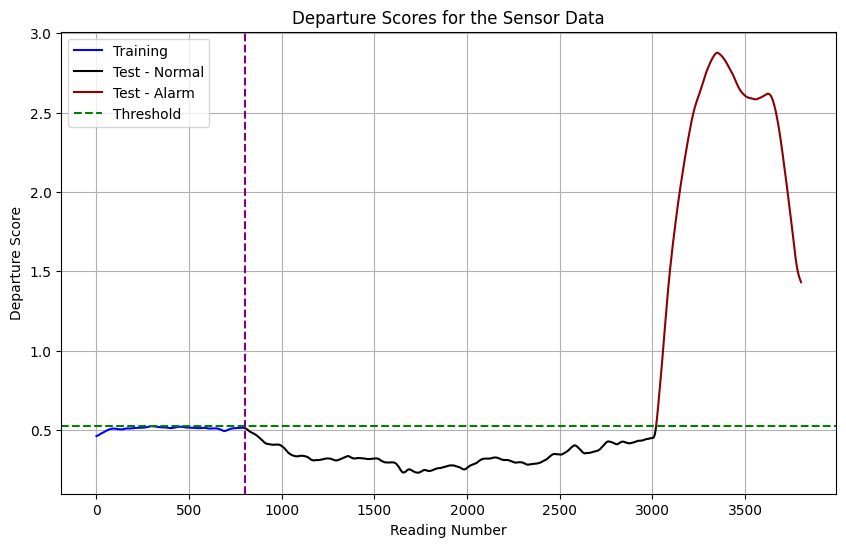

<Figure size 640x480 with 0 Axes>

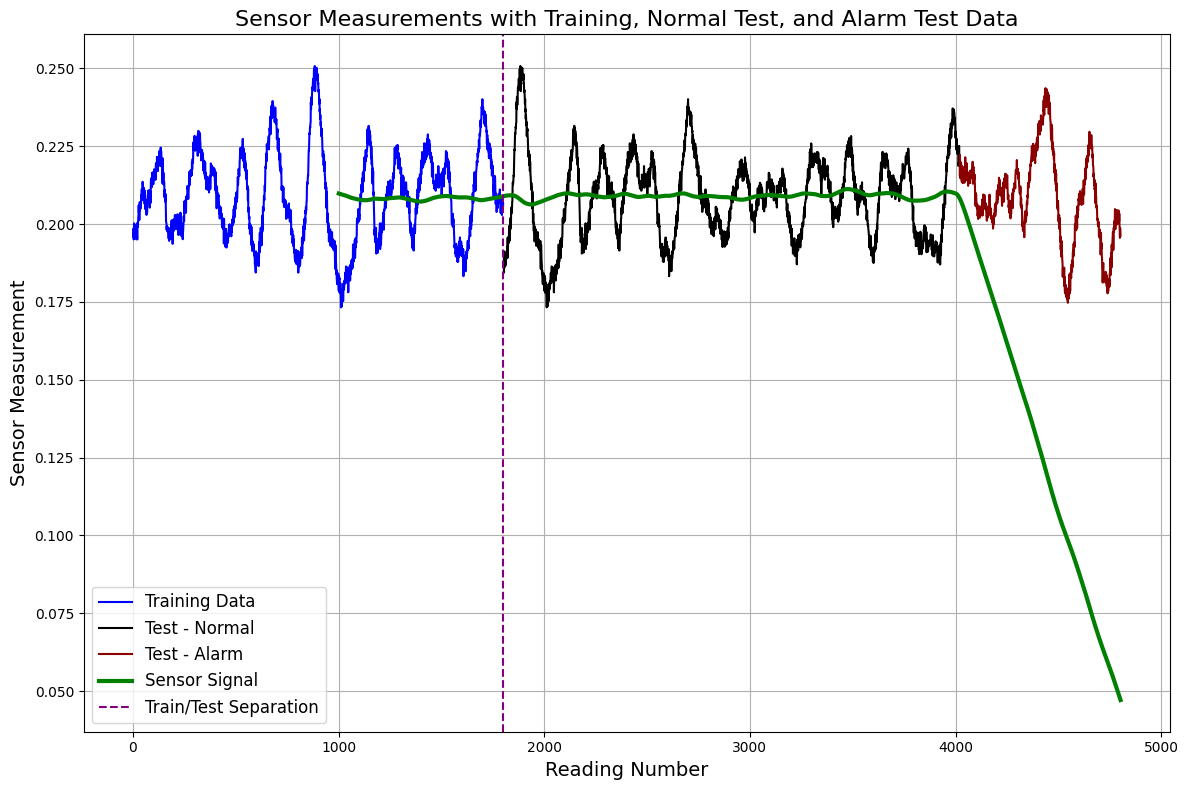

The total number of Alarms raised are 783
Time Taken: 39.477298736572266 seconds


In [14]:
# Applying Pasad to the different Sensors for DA2

Start = time.time()
AlarmCountDict['DA2'] = Pasad(da2[0:1800], da2[1800 - LagParameter_TE + 1:], LagParameter_TE, Sufficient_Variance_to_Capture)
End = time.time()

AverageTimeTaken += End - Start
print("Time Taken:", End - Start, "seconds")

The average time taken by the Pasad Method is 78.49502806663513
The alarm Counts are {'SA1': 790, 'SA2': 1134, 'SA3': 1795, 'DA1': 621, 'DA2': 783}


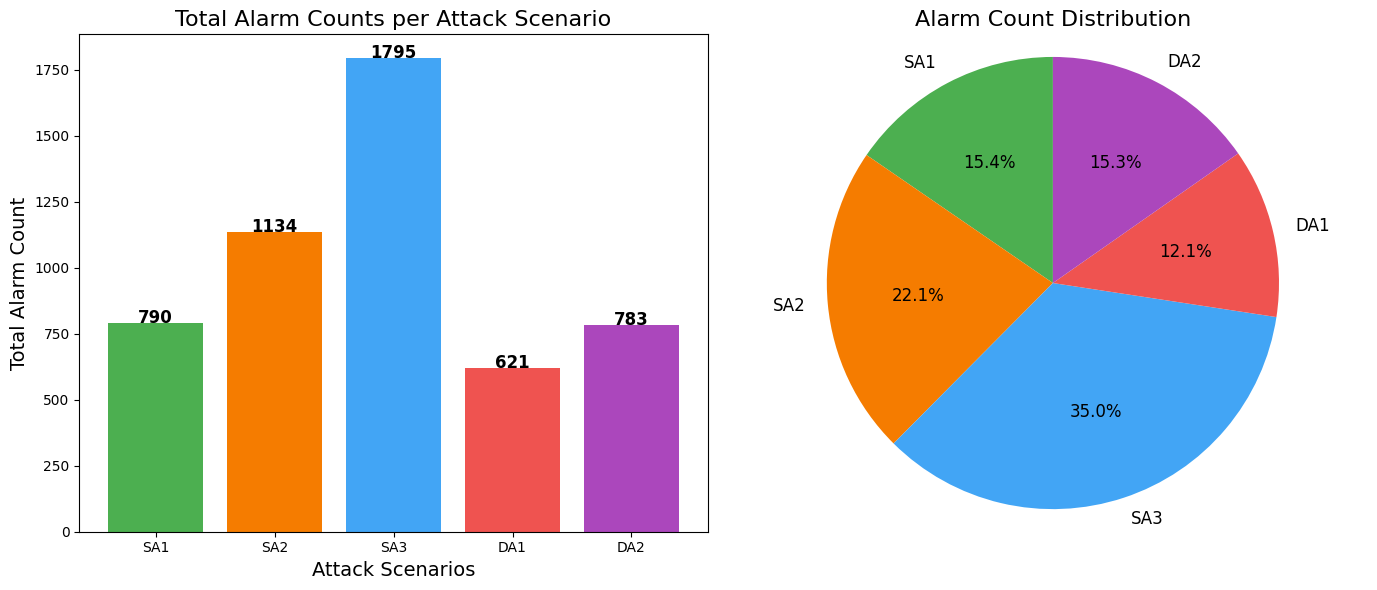

In [15]:
# Time Analysis and Alarm Count Plots for the Tennesse Eastman Sensors

print("The average time taken by the Pasad Method is", AverageTimeTaken/5)
print("The alarm Counts are", AlarmCountDict)
# Separate the attack scenarios
scenarios = list(AlarmCountDict.keys())
counts = list(AlarmCountDict.values())

# Define lighter colors for SA and DA bars in a simple theme
colors = ['#4caf50', '#f57c00', '#42a5f5', '#ef5350', '#ab47bc']  # Light colors

# Create a figure and axis for the bar plot and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for total alarm counts
ax1.bar(scenarios, counts, color=colors)
ax1.set_title('Total Alarm Counts per Attack Scenario', fontsize=16)
ax1.set_xlabel('Attack Scenarios', fontsize=14)
ax1.set_ylabel('Total Alarm Count', fontsize=14)

# Add alarm counts as labels on each bar with larger font size and better positioning
for i, count in enumerate(counts):
    ax1.text(i, count + 0.5, str(count), ha='center', fontsize=12, fontweight='bold')

# Pie chart to visualize the distribution
ax2.pie(counts, labels=scenarios, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Alarm Count Distribution', fontsize=16)

# Equal axis for pie chart
ax2.axis('equal')

# Show both plots
plt.tight_layout()
plt.show()

Statistical Dimension: 25


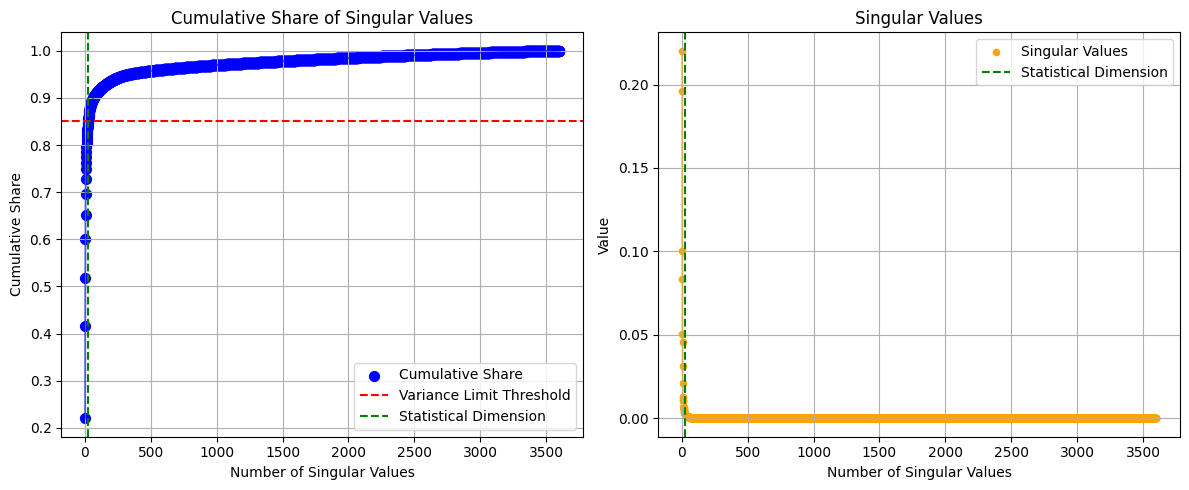

The threshold theta for Alarm is 8105.832176361514


In [ ]:
# Secure Water Treatment Dataset

# Applying Pasad to the different Sensors for SWaT

Start = time.time()
Pasad(SWaT[0:TrainingValues], SWaT[TrainingValues - LagParameter_SWaT + 1:], LagParameter_SWaT, Sufficient_Variance_to_Capture)
End = time.time()

print("Time Taken:", End - Start, "seconds")

Statistical Dimension: 25


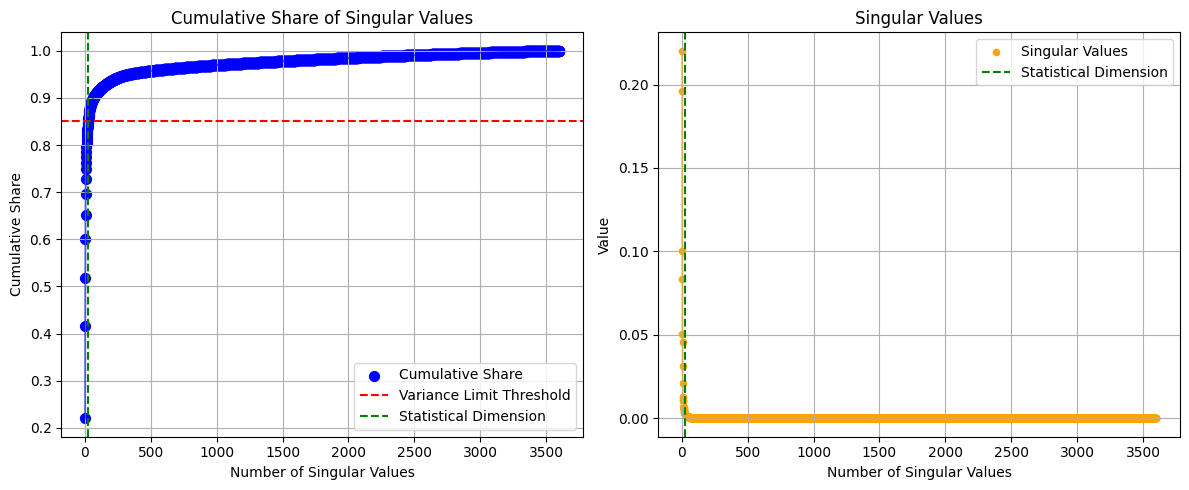

25
The threshold theta for Alarm is 8105.832176361505


<Figure size 640x480 with 0 Axes>

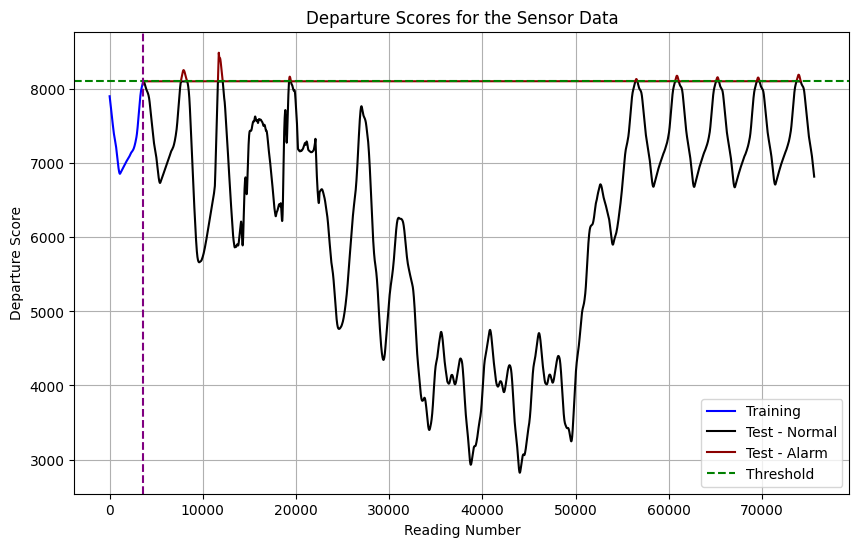

<Figure size 640x480 with 0 Axes>

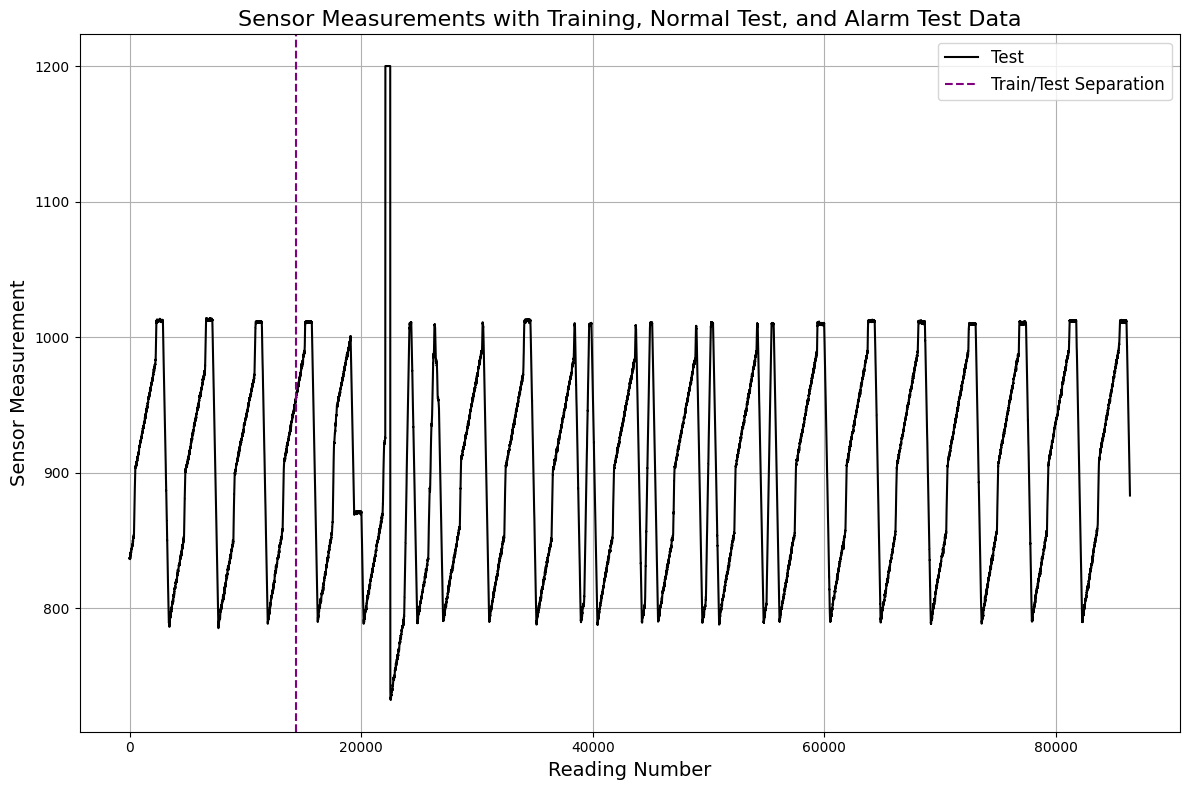

The total number of Alarms raised are 3160
Time Taken: 75.213632106781 seconds


In [ ]:
# Applying Pasad to the different Sensors for SWaT

Start = time.time()
Pasad(SWaT[0:TrainingValues], SWaT[TrainingValues - LagParameter_SWaT + 1:], LagParameter_SWaT, Sufficient_Variance_to_Capture, 1)
End = time.time()

print("Time Taken:", End - Start, "seconds")